# JER vs. $\rho$ Plotting

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from distributed.diagnostics.plugin import UploadDirectory
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pickle
import correctionlib
from coffea.analysis_tools import PackedSelection
from dask.distributed import Client
from scipy.optimize import curve_fit
import csv
import pandas as pd
from python.smp_utils import *

In [2]:
with open("pkl_files/QCD_pt_response_04-29.pkl", "rb") as f:
    output = pickle.load(f)

histogram_bins = histogram_bin_extractor(output["responses_histogram_rho"])

eras = histogram_bins[0]
dataset_bin_edges, frac_bin_edges, eta_bin_edges, pt_bin_edges, rho_bin_edges = histogram_bins[1]
dataset_bin_centers, frac_bin_centers, eta_bin_centers, pt_bin_centers, rho_bin_centers = histogram_bins[2]
dataset_bin_widths, frac_bin_widths, eta_bin_widths, pt_bin_widths, rho_bin_widths = histogram_bins[3]

pt_bin_centers = pt_bin_centers[0:24]
pt_bin_edges = pt_bin_edges[0:25]

print(f'pT bin centers:\n{pt_bin_centers}\n')
print(f'pT bin edges:\n{pt_bin_edges}\n')
print(f'rho bin edges:\n{rho_bin_edges}\n')
print(f'eta bin edges:\n{eta_bin_edges}\n')

labels_list = []

for pt_bin in pt_bin_centers:
    for j in range(len(pt_bin_edges) - 1):
        if pt_bin_edges[j] <= pt_bin < pt_bin_edges[j + 1]:
            label = f"${pt_bin_edges[j]} < p_{{T}} < {pt_bin_edges[j + 1]}$"
            labels_list.append(label)
            break

pT bin centers:
[  15.    25.    32.5   37.5   42.5   51.    64.5   81.   105.   135.
  175.   250.   350.   475.   650.   875.  1125.  1375.  1625.  1875.
 2125.  2375.  2625.  2875. ]

pT bin edges:
[  10.   20.   30.   35.   40.   45.   57.   72.   90.  120.  150.  200.
  300.  400.  550.  750. 1000. 1250. 1500. 1750. 2000. 2250. 2500. 2750.
 3000.]

rho bin edges:
[ 0.    7.32 13.2  19.08 24.95 30.83 36.71 90.  ]

eta bin edges:
[0.  0.5 0.8 1.1 1.3 1.7 1.9 2.1 2.3 2.5 2.8 3.  3.2 4.7]



### 2018 Dataset

In [3]:
era = 2018

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)
    
max_rho_bin = 7
max_eta_bin = 13
min_pt_bin = 1
max_pt_bin = 12
    
total_pt_bin_lists = [[] for l in range(max_eta_bin)]
total_sigmas_lists = [[] for l in range(max_eta_bin)]
total_sigma_errs_lists = [[] for l in range(max_eta_bin)]
total_filenames_lists = [[] for l in range(max_eta_bin)]

for j in range(max_eta_bin):
    for k in range(min_pt_bin, max_pt_bin):
        pts = [pt_bin_lists[j][i][k] for i in range(max_rho_bin)]
        sigmas = [sigmas_lists[j][i][k] for i in range(max_rho_bin)]
        sigma_errs = [sigma_errs_lists[j][i][k] for i in range(max_rho_bin)]
        filenames = [filenames_lists[j][i] for i in range(max_rho_bin)]
        
        total_pt_bin_lists[j].append(pts)
        total_sigmas_lists[j].append(sigmas)
        total_sigma_errs_lists[j].append(sigma_errs)
        total_filenames_lists[j].append(filenames)
        
labels_list = labels_list[min_pt_bin:]

### Barrel Measurements

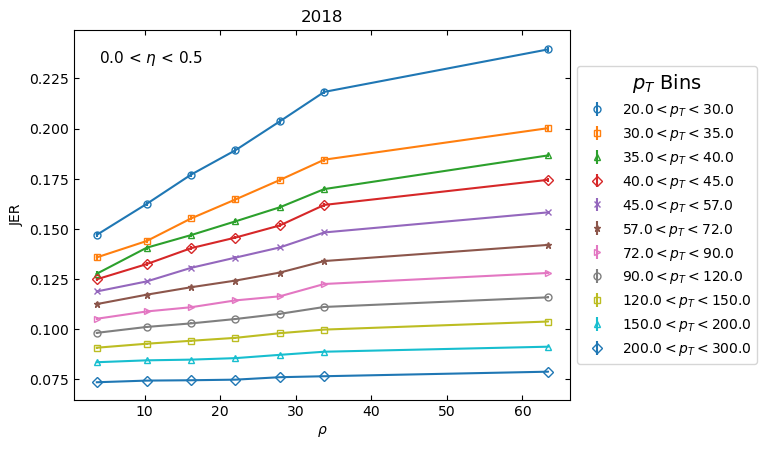

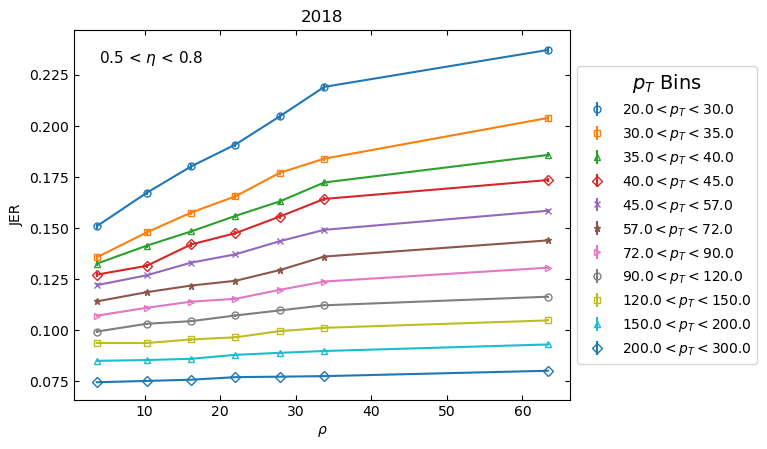

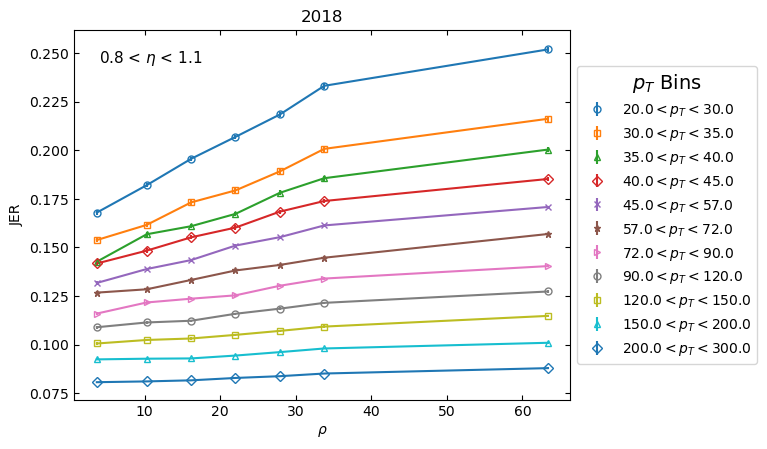

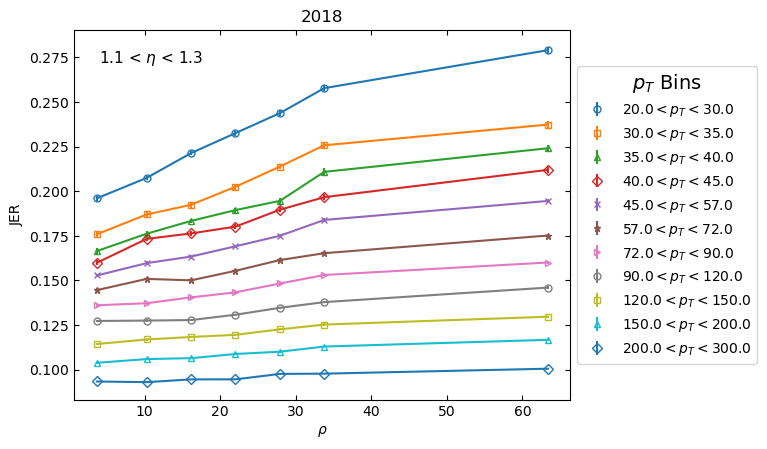

In [4]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[0], total_sigma_errs_lists[0], labels_list, total_filenames_lists[0])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[1], total_sigma_errs_lists[1], labels_list, total_filenames_lists[1])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[2], total_sigma_errs_lists[2], labels_list, total_filenames_lists[2])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[3], total_sigma_errs_lists[3], labels_list, total_filenames_lists[3])

### Endcap measurements

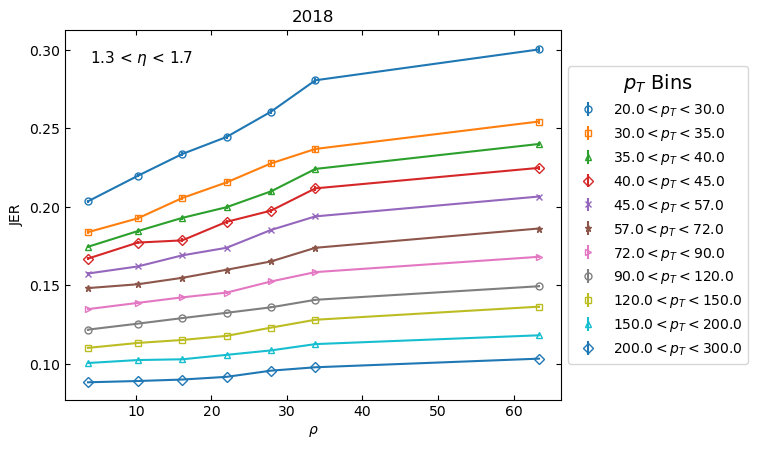

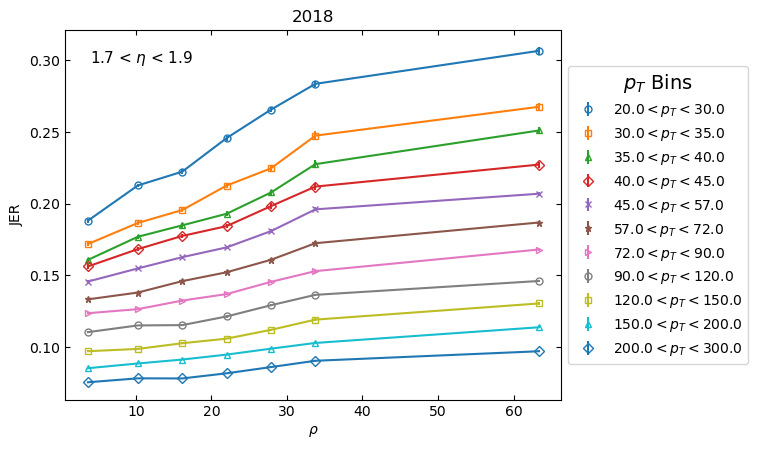

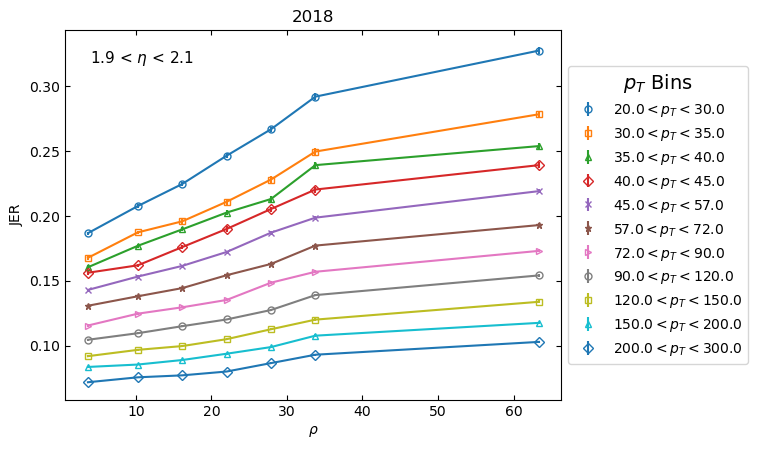

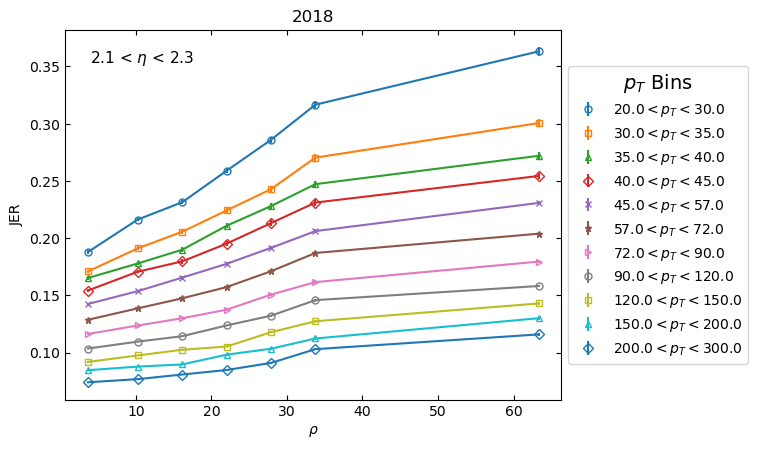

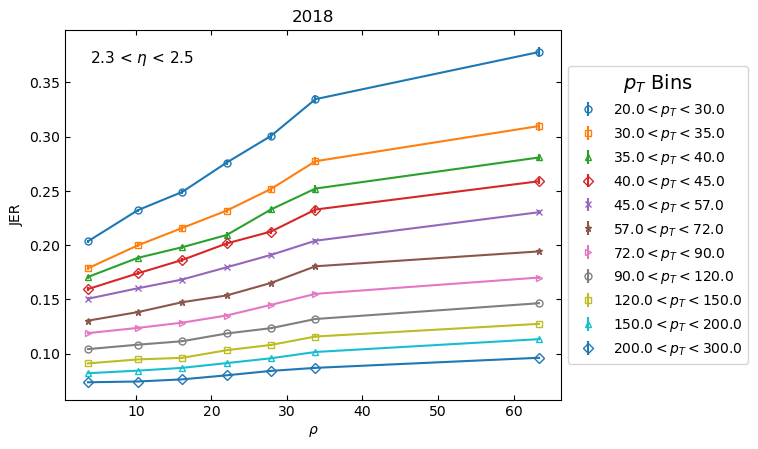

In [5]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[4], total_sigma_errs_lists[4], labels_list, total_filenames_lists[4])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[5], total_sigma_errs_lists[5], labels_list, total_filenames_lists[5])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[6], total_sigma_errs_lists[6], labels_list, total_filenames_lists[6])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[7], total_sigma_errs_lists[7], labels_list, total_filenames_lists[7])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[8], total_sigma_errs_lists[8], labels_list, total_filenames_lists[8])

### Forward measurements

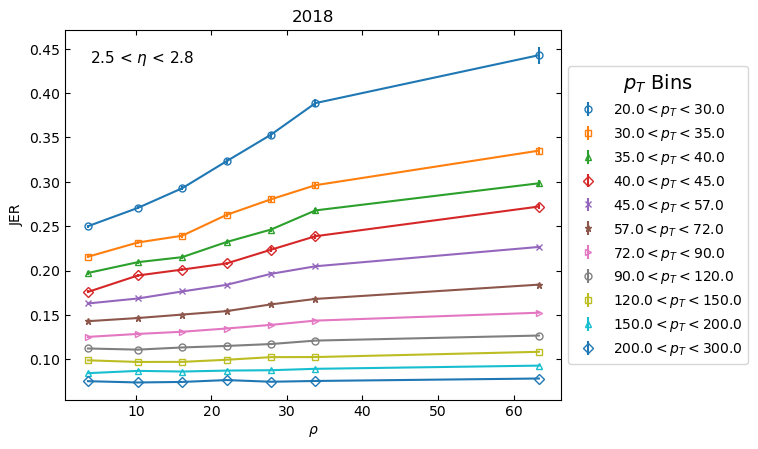

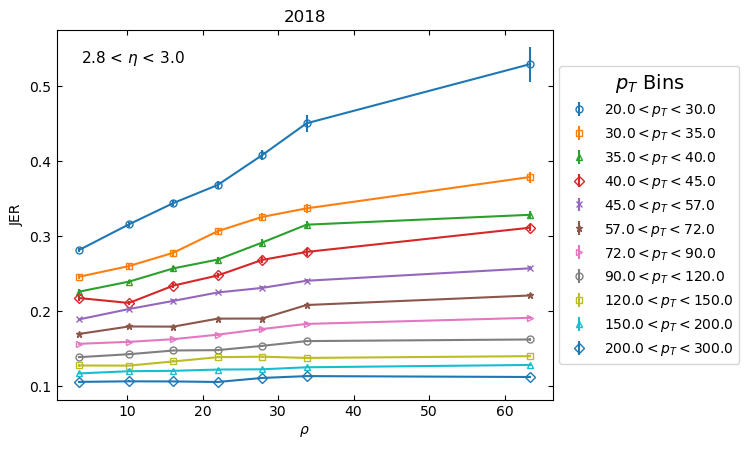

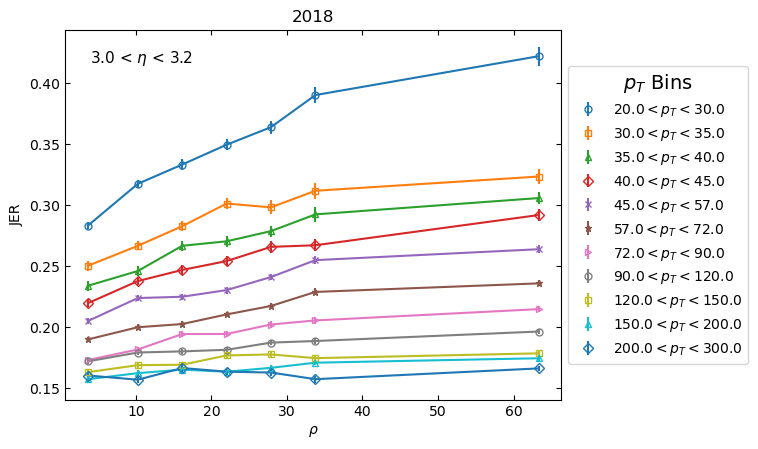

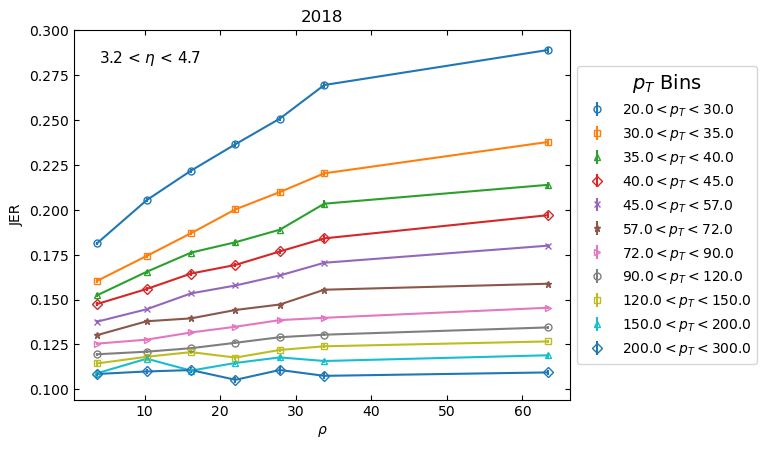

In [6]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[9], total_sigma_errs_lists[9], labels_list, total_filenames_lists[9])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[10], total_sigma_errs_lists[10], labels_list, total_filenames_lists[10])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[11], total_sigma_errs_lists[11], labels_list, total_filenames_lists[11])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[12], total_sigma_errs_lists[12], labels_list, total_filenames_lists[12])

### 2017 Dataset

In [7]:
era = 2017

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)
    
max_rho_bin = 7
max_eta_bin = 13
min_pt_bin = 1
max_pt_bin = 12
    
total_pt_bin_lists = [[] for l in range(max_eta_bin)]
total_sigmas_lists = [[] for l in range(max_eta_bin)]
total_sigma_errs_lists = [[] for l in range(max_eta_bin)]
total_filenames_lists = [[] for l in range(max_eta_bin)]

for j in range(max_eta_bin):
    for k in range(min_pt_bin, max_pt_bin):
        pts = [pt_bin_lists[j][i][k] for i in range(max_rho_bin)]
        sigmas = [sigmas_lists[j][i][k] for i in range(max_rho_bin)]
        sigma_errs = [sigma_errs_lists[j][i][k] for i in range(max_rho_bin)]
        filenames = [filenames_lists[j][i] for i in range(max_rho_bin)]
        
        total_pt_bin_lists[j].append(pts)
        total_sigmas_lists[j].append(sigmas)
        total_sigma_errs_lists[j].append(sigma_errs)
        total_filenames_lists[j].append(filenames)
        
labels_list = labels_list[min_pt_bin:]

### Barrel measurements

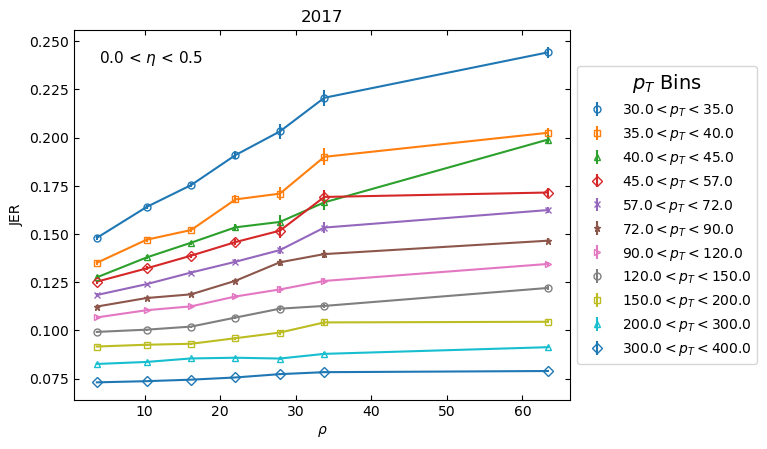

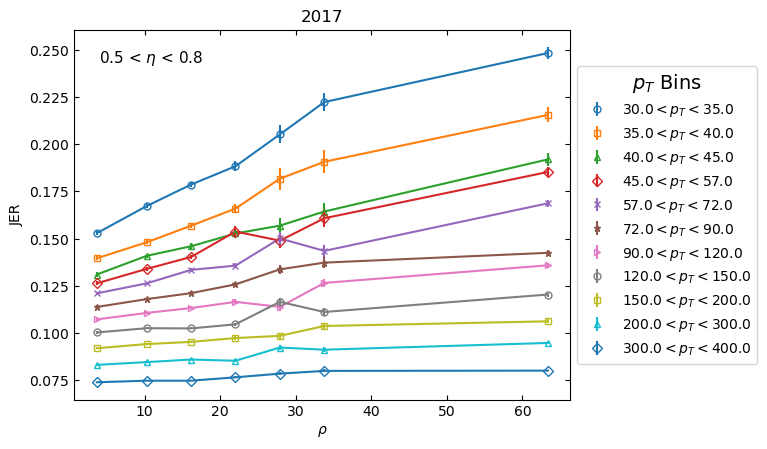

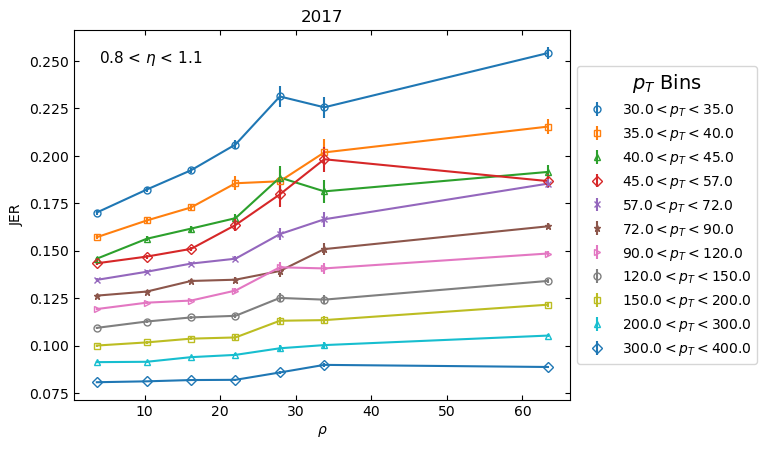

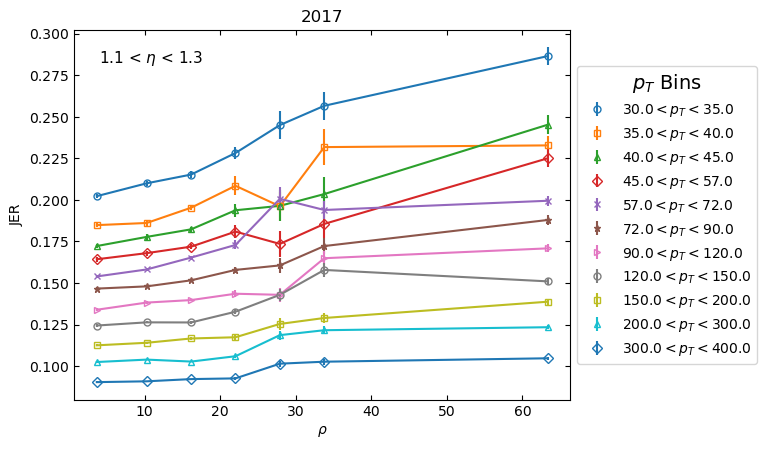

In [8]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[0], total_sigma_errs_lists[0], labels_list, total_filenames_lists[0])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[1], total_sigma_errs_lists[1], labels_list, total_filenames_lists[1])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[2], total_sigma_errs_lists[2], labels_list, total_filenames_lists[2])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[3], total_sigma_errs_lists[3], labels_list, total_filenames_lists[3])

### Endcap measurements

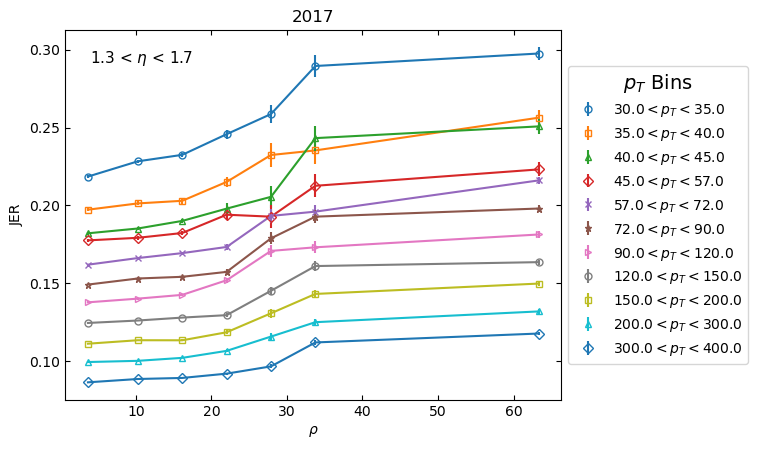

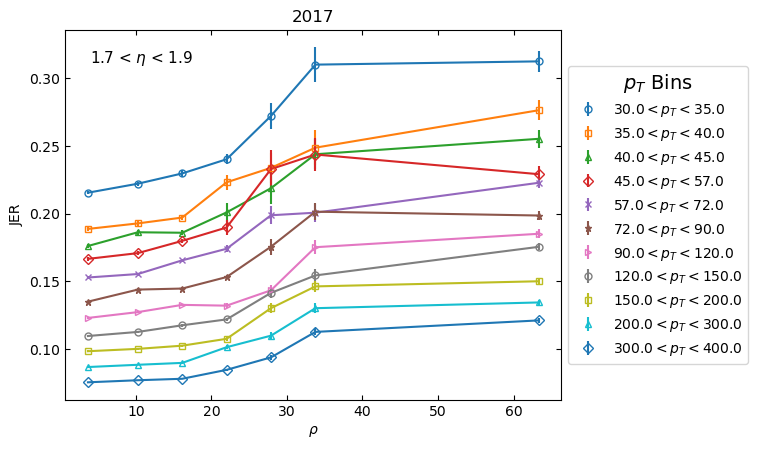

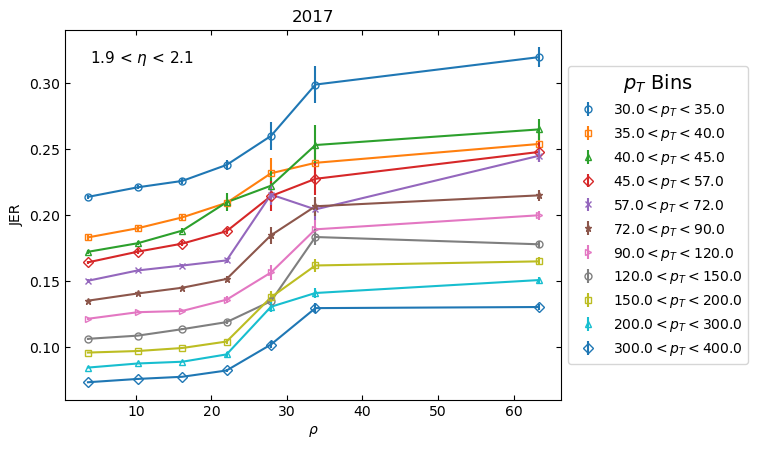

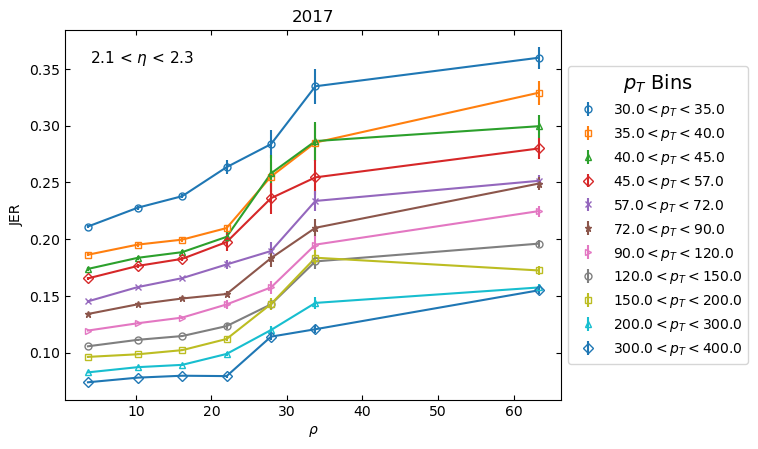

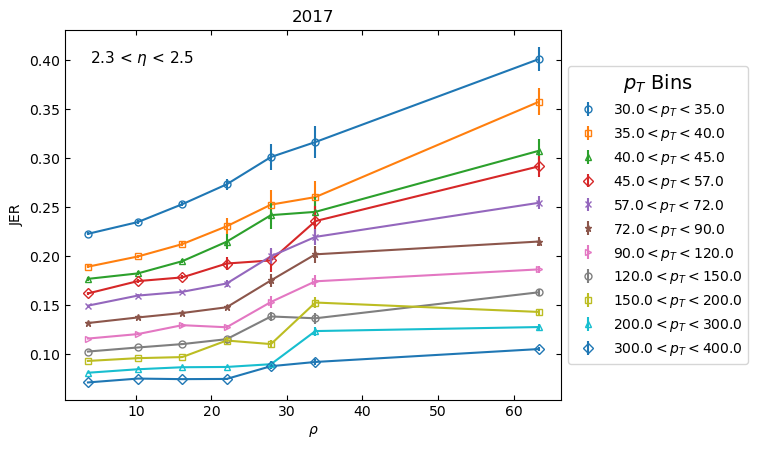

In [9]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[4], total_sigma_errs_lists[4], labels_list, total_filenames_lists[4])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[5], total_sigma_errs_lists[5], labels_list, total_filenames_lists[5])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[6], total_sigma_errs_lists[6], labels_list, total_filenames_lists[6])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[7], total_sigma_errs_lists[7], labels_list, total_filenames_lists[7])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[8], total_sigma_errs_lists[8], labels_list, total_filenames_lists[8])

### Forward measurements

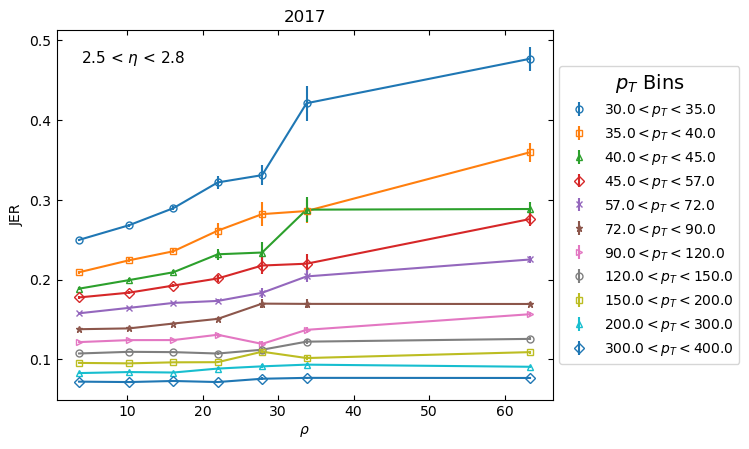

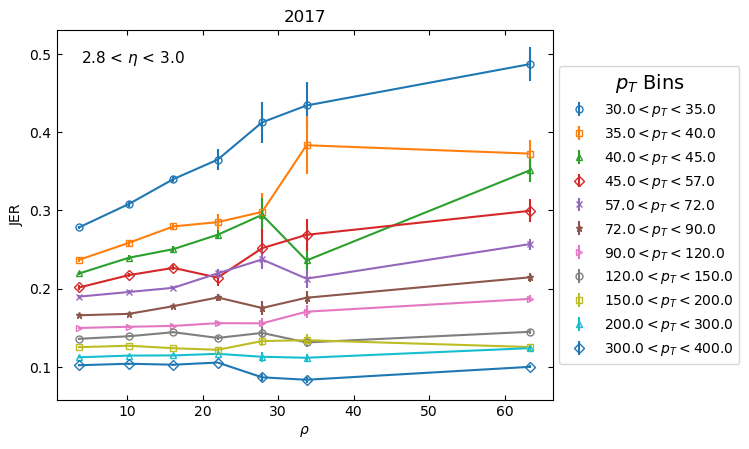

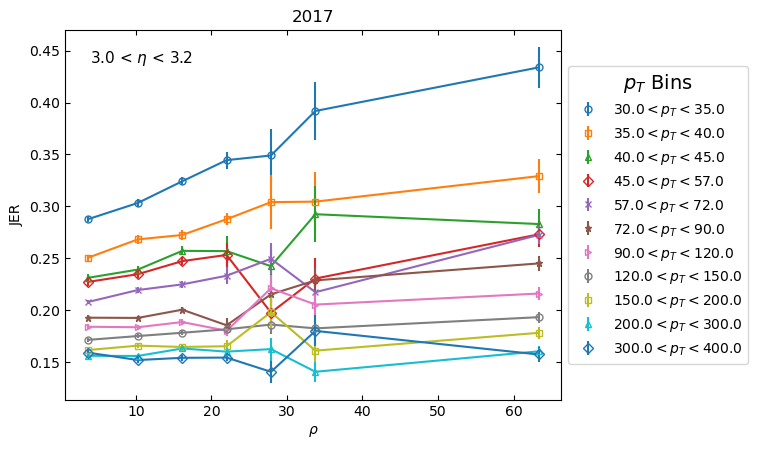

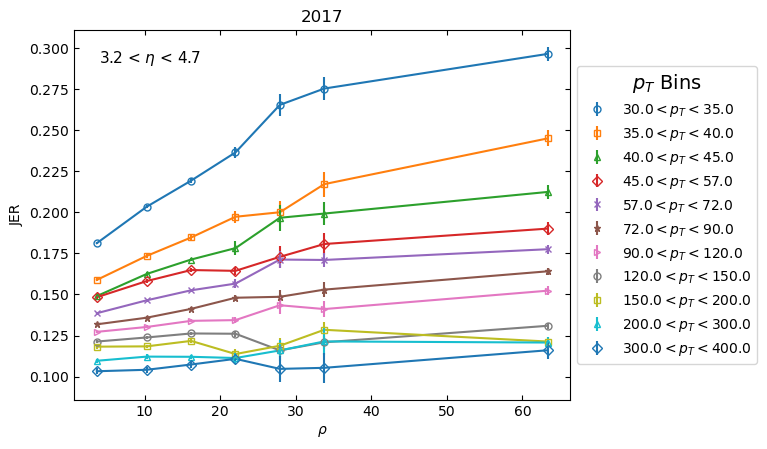

In [10]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[9], total_sigma_errs_lists[9], labels_list, total_filenames_lists[9])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[10], total_sigma_errs_lists[10], labels_list, total_filenames_lists[10])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[11], total_sigma_errs_lists[11], labels_list, total_filenames_lists[11])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[12], total_sigma_errs_lists[12], labels_list, total_filenames_lists[12])

### 2016APV Dataset

In [11]:
era = '2016APV'

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)
    
max_rho_bin = 7
max_eta_bin = 13
min_pt_bin = 1
max_pt_bin = 12
    
total_pt_bin_lists = [[] for l in range(max_eta_bin)]
total_sigmas_lists = [[] for l in range(max_eta_bin)]
total_sigma_errs_lists = [[] for l in range(max_eta_bin)]
total_filenames_lists = [[] for l in range(max_eta_bin)]

for j in range(max_eta_bin):
    for k in range(min_pt_bin, max_pt_bin):
        pts = [pt_bin_lists[j][i][k] for i in range(max_rho_bin)]
        sigmas = [sigmas_lists[j][i][k] for i in range(max_rho_bin)]
        sigma_errs = [sigma_errs_lists[j][i][k] for i in range(max_rho_bin)]
        filenames = [filenames_lists[j][i] for i in range(max_rho_bin)]
        
        total_pt_bin_lists[j].append(pts)
        total_sigmas_lists[j].append(sigmas)
        total_sigma_errs_lists[j].append(sigma_errs)
        total_filenames_lists[j].append(filenames)
        
labels_list = labels_list[min_pt_bin:]

### Barrel measurements

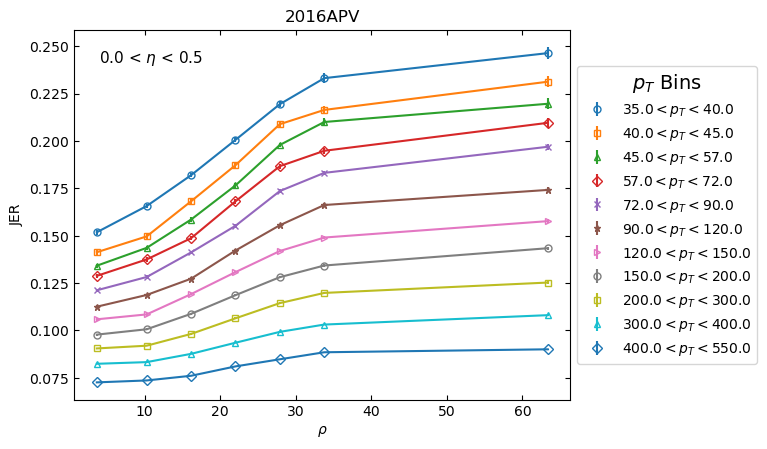

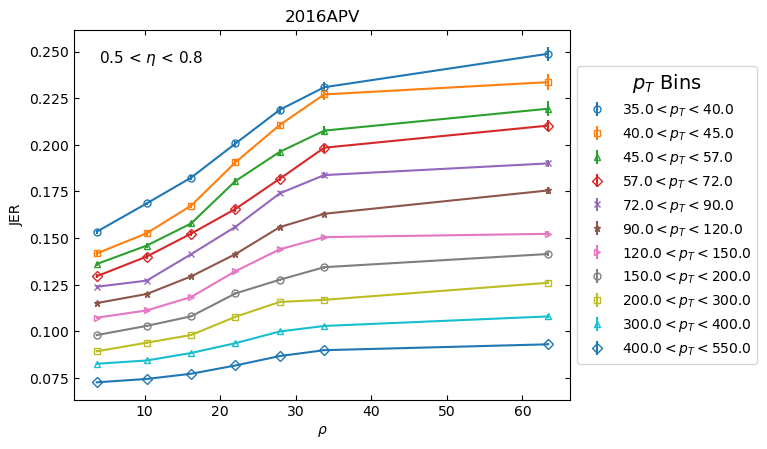

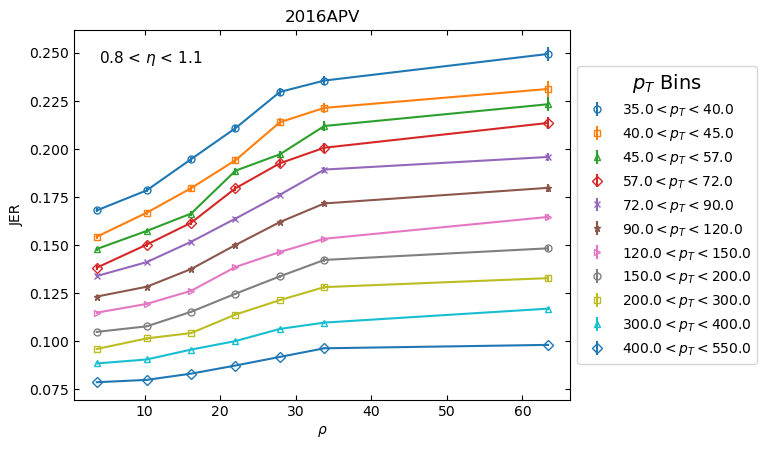

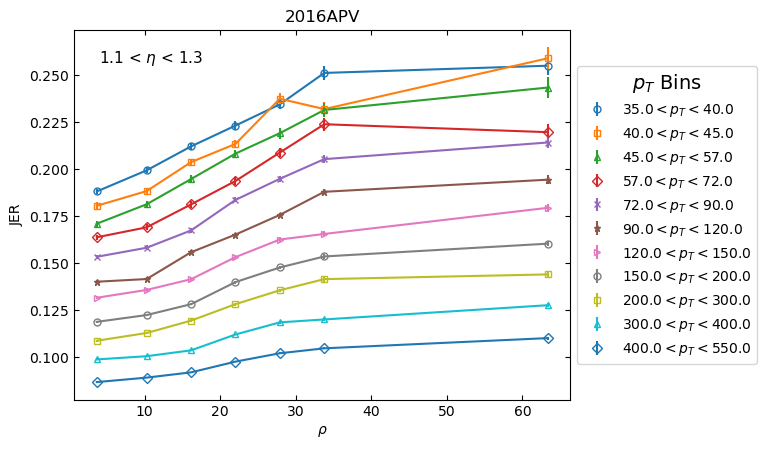

In [12]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[0], total_sigma_errs_lists[0], labels_list, total_filenames_lists[0])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[1], total_sigma_errs_lists[1], labels_list, total_filenames_lists[1])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[2], total_sigma_errs_lists[2], labels_list, total_filenames_lists[2])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[3], total_sigma_errs_lists[3], labels_list, total_filenames_lists[3])

### Endcap measurements

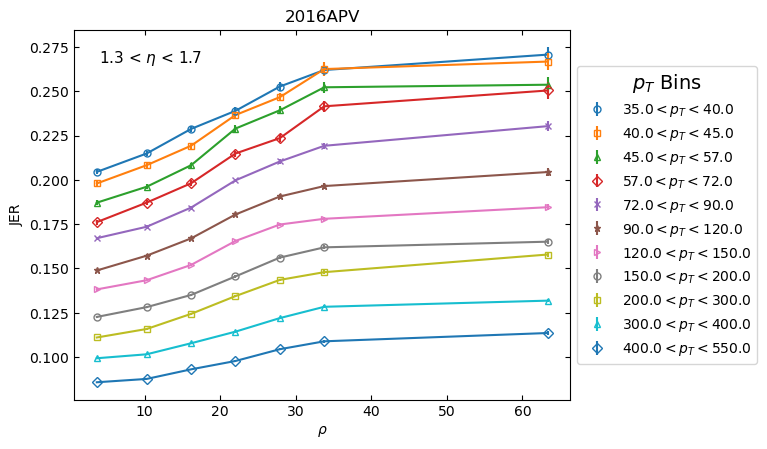

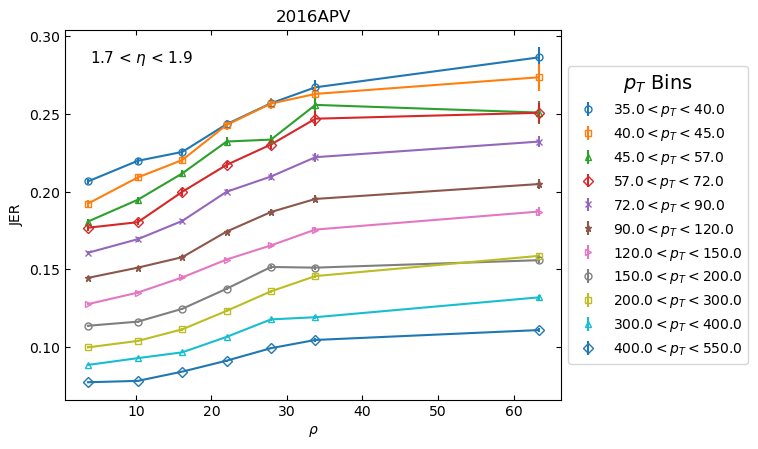

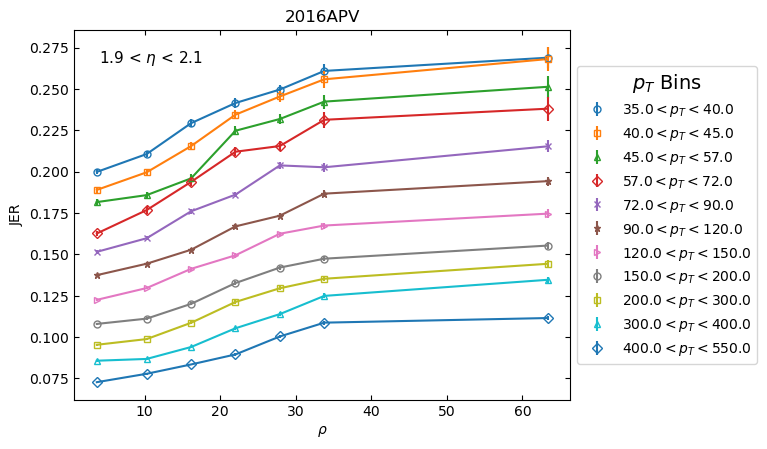

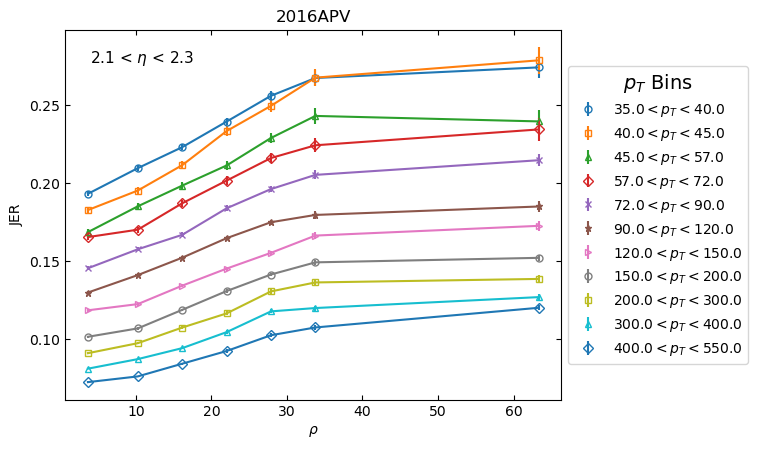

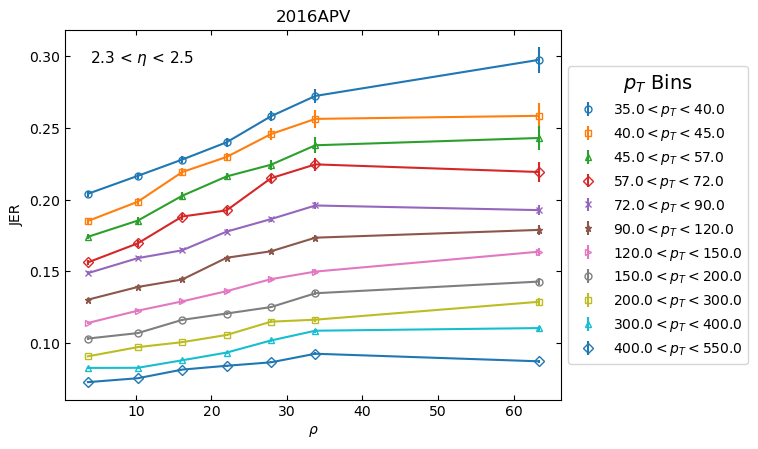

In [13]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[4], total_sigma_errs_lists[4], labels_list, total_filenames_lists[4])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[5], total_sigma_errs_lists[5], labels_list, total_filenames_lists[5])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[6], total_sigma_errs_lists[6], labels_list, total_filenames_lists[6])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[7], total_sigma_errs_lists[7], labels_list, total_filenames_lists[7])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[8], total_sigma_errs_lists[8], labels_list, total_filenames_lists[8])

### Forward measurements

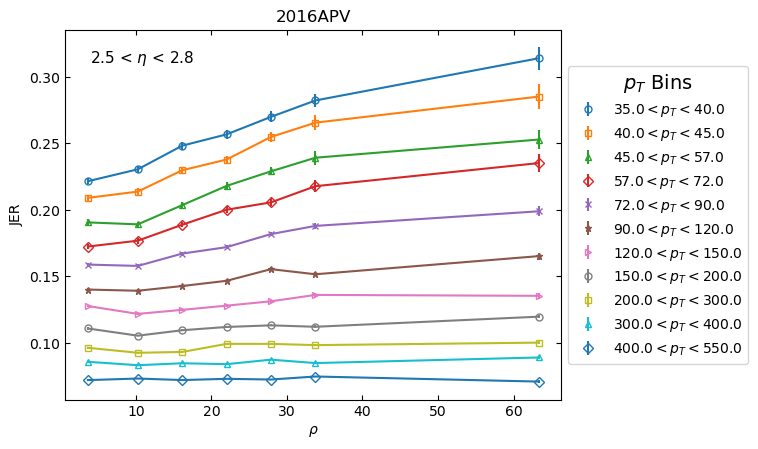

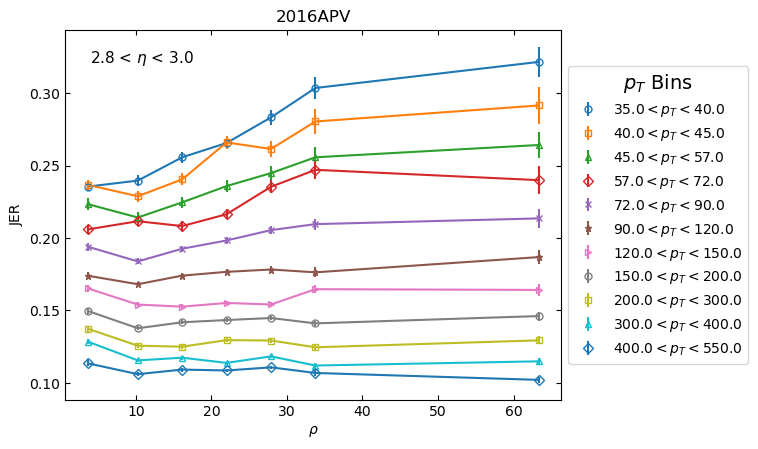

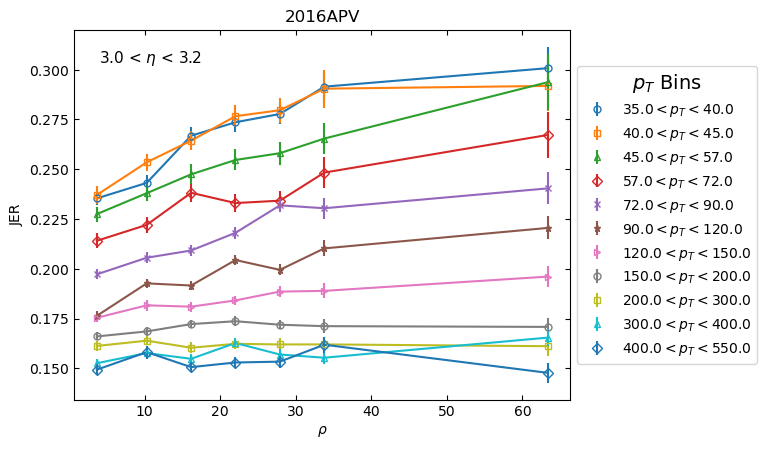

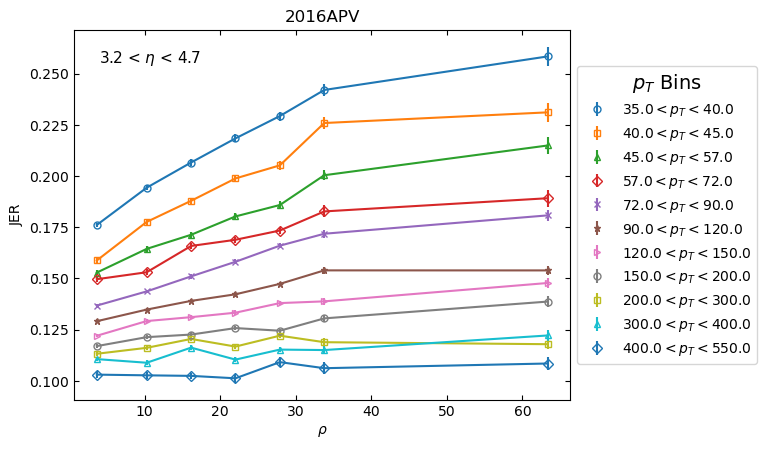

In [14]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[9], total_sigma_errs_lists[9], labels_list, total_filenames_lists[9])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[10], total_sigma_errs_lists[10], labels_list, total_filenames_lists[10])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[11], total_sigma_errs_lists[11], labels_list, total_filenames_lists[11])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[12], total_sigma_errs_lists[12], labels_list, total_filenames_lists[12])

### 2016 Dataset

In [15]:
era = 2016

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)
    
max_rho_bin = 7
max_eta_bin = 13
min_pt_bin = 1
max_pt_bin = 12
    
total_pt_bin_lists = [[] for l in range(max_eta_bin)]
total_sigmas_lists = [[] for l in range(max_eta_bin)]
total_sigma_errs_lists = [[] for l in range(max_eta_bin)]
total_filenames_lists = [[] for l in range(max_eta_bin)]

for j in range(max_eta_bin):
    for k in range(min_pt_bin, max_pt_bin):
        pts = [pt_bin_lists[j][i][k] for i in range(max_rho_bin)]
        sigmas = [sigmas_lists[j][i][k] for i in range(max_rho_bin)]
        sigma_errs = [sigma_errs_lists[j][i][k] for i in range(max_rho_bin)]
        filenames = [filenames_lists[j][i] for i in range(max_rho_bin)]
        
        total_pt_bin_lists[j].append(pts)
        total_sigmas_lists[j].append(sigmas)
        total_sigma_errs_lists[j].append(sigma_errs)
        total_filenames_lists[j].append(filenames)
        
labels_list = labels_list[min_pt_bin:]

### Barrel measurements

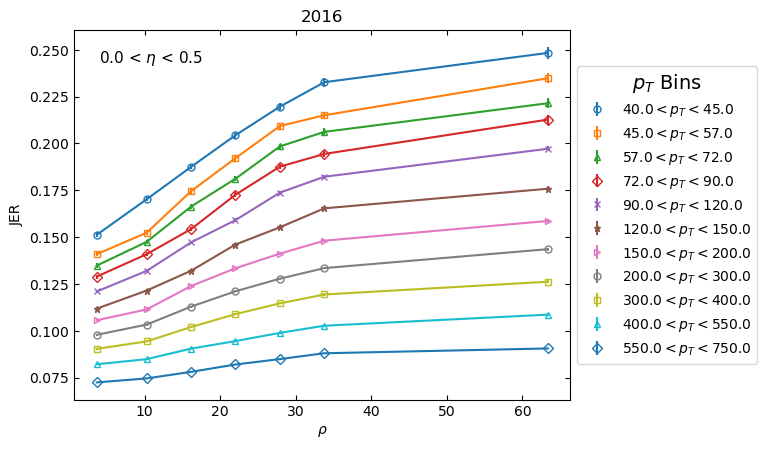

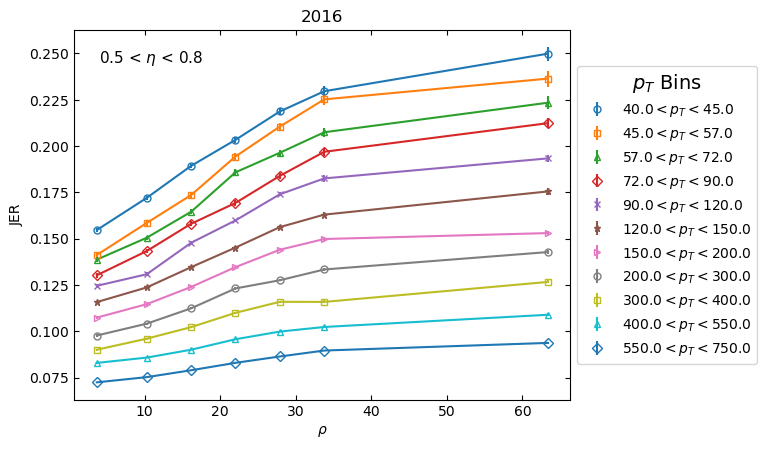

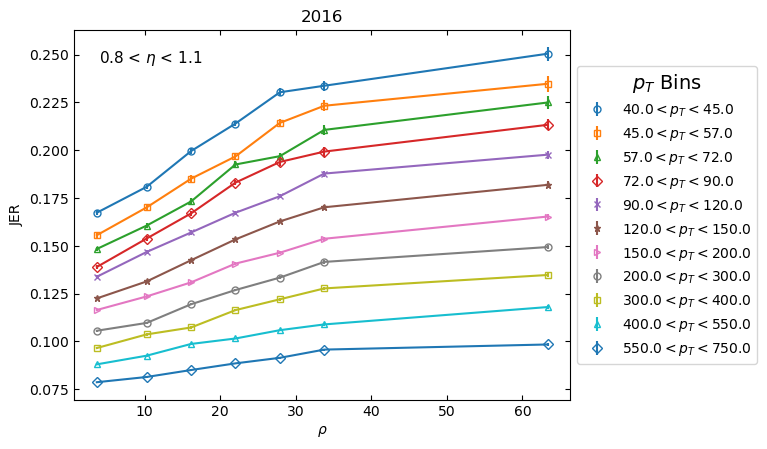

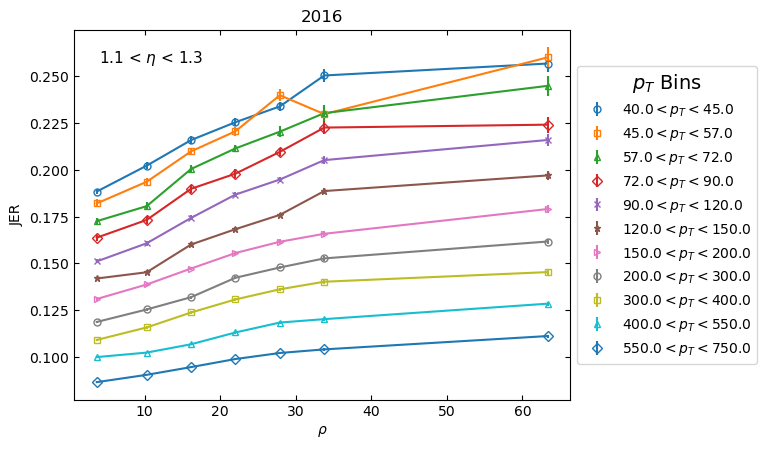

In [16]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[0], total_sigma_errs_lists[0], labels_list, total_filenames_lists[0])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[1], total_sigma_errs_lists[1], labels_list, total_filenames_lists[1])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[2], total_sigma_errs_lists[2], labels_list, total_filenames_lists[2])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[3], total_sigma_errs_lists[3], labels_list, total_filenames_lists[3])

### Endcap measurements

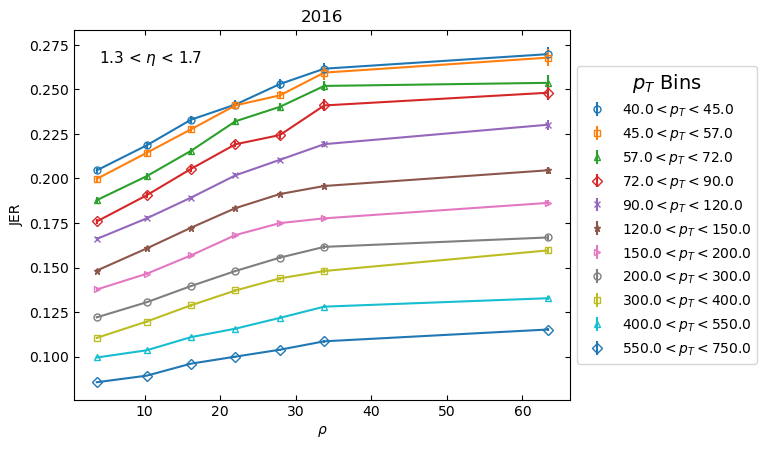

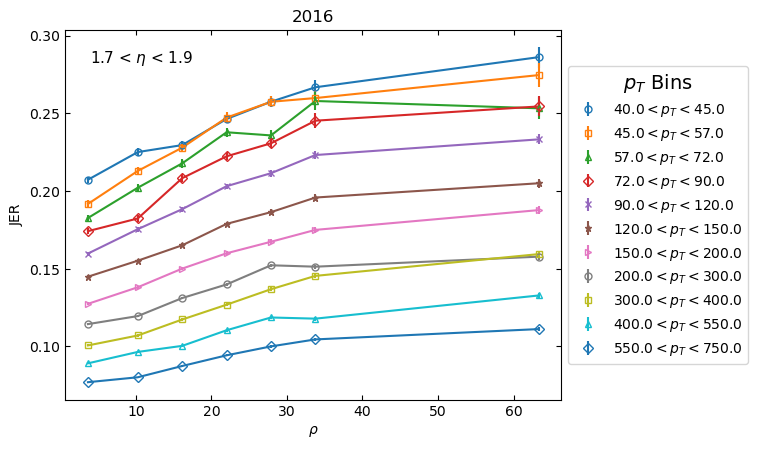

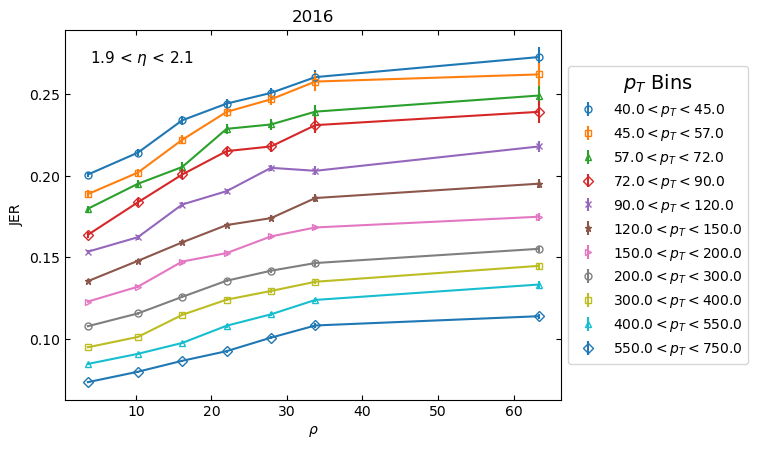

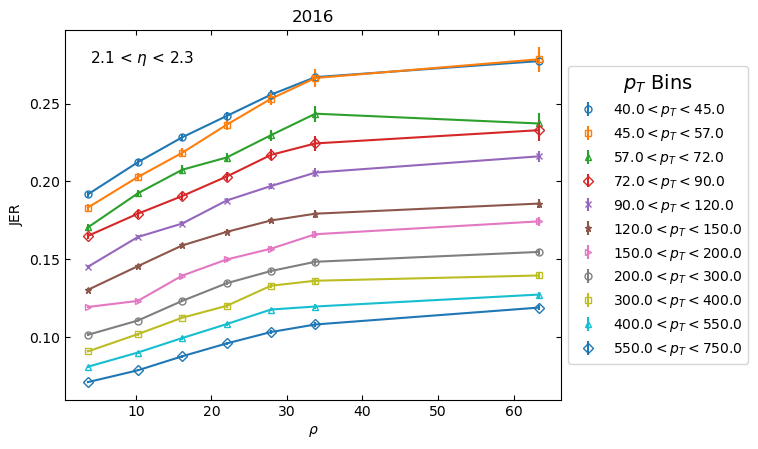

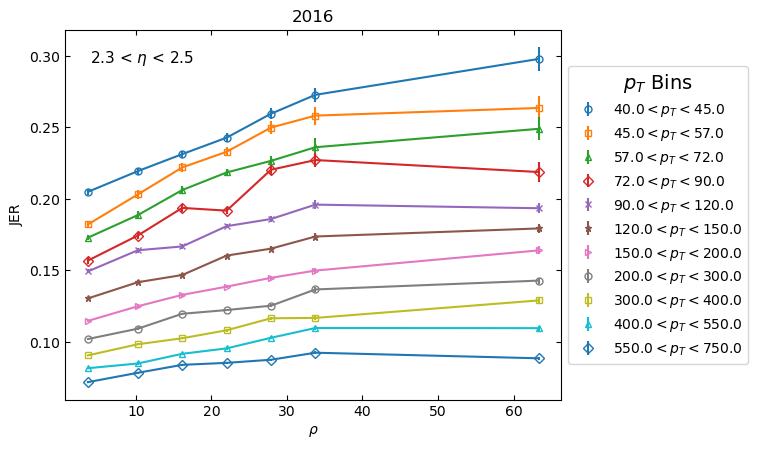

In [17]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[4], total_sigma_errs_lists[4], labels_list, total_filenames_lists[4])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[5], total_sigma_errs_lists[5], labels_list, total_filenames_lists[5])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[6], total_sigma_errs_lists[6], labels_list, total_filenames_lists[6])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[7], total_sigma_errs_lists[7], labels_list, total_filenames_lists[7])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[8], total_sigma_errs_lists[8], labels_list, total_filenames_lists[8])

### Forward measurements

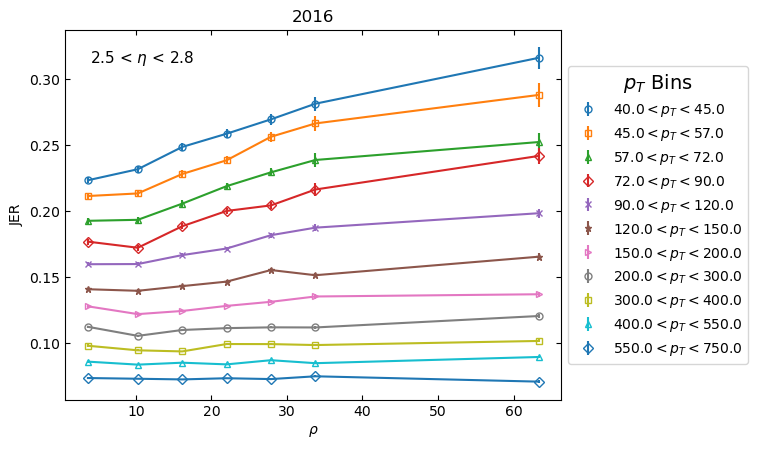

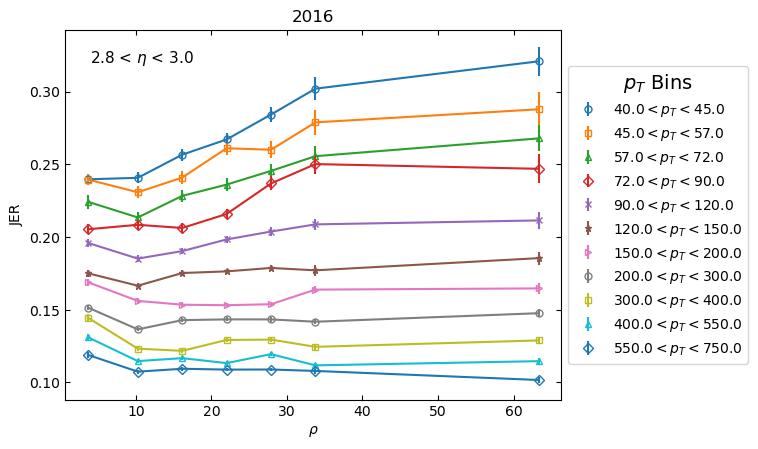

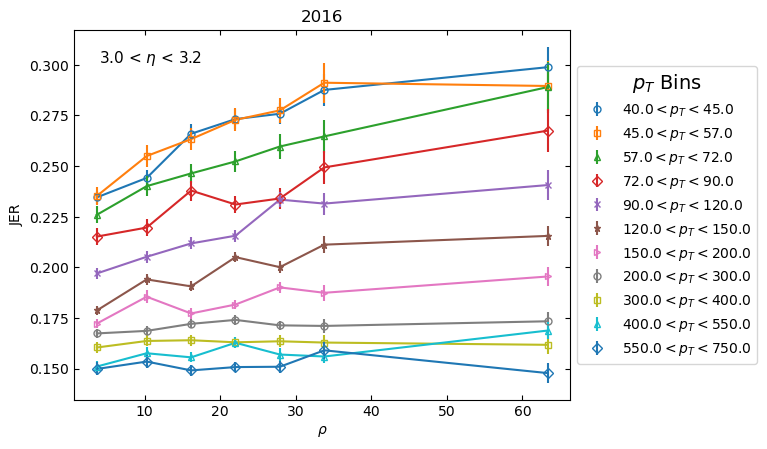

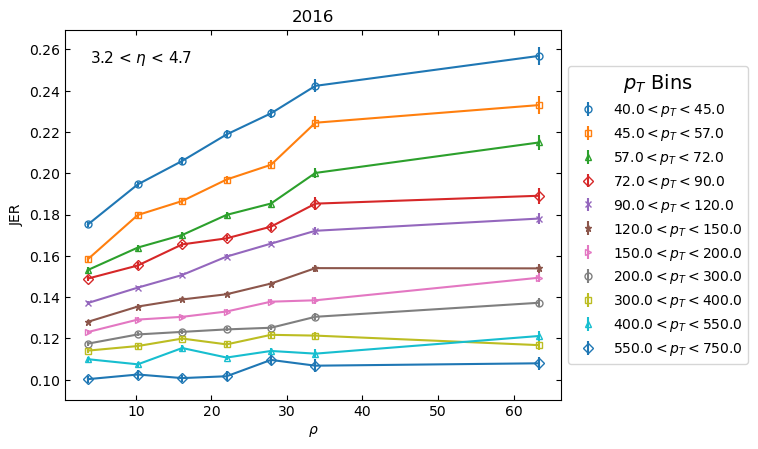

In [18]:
plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[9], total_sigma_errs_lists[9], labels_list, total_filenames_lists[9])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[10], total_sigma_errs_lists[10], labels_list, total_filenames_lists[10])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[11], total_sigma_errs_lists[11], labels_list, total_filenames_lists[11])

plot_jer_vs_rho(rho_bin_centers, total_sigmas_lists[12], total_sigma_errs_lists[12], labels_list, total_filenames_lists[12])